In [11]:
import torch

import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from IPython.display import HTML

from sincnet.model import SincNet, Quantizer, compute_forward_mu_law_companding
from datasets.utils.waveform import WaveformLoader

In [12]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [13]:
SAMPLE_RATE = 16_000
audio_loader = WaveformLoader(sample_rate=SAMPLE_RATE)

Initializing PreprocessingWaveformLoader with sample rate sr:16000...


In [14]:
from datasets.configs import GTZANConfig

config = GTZANConfig()
weights_folder = "pretrained"
#weights_folder = f"training/trainings/{config.id}/ckpt"

In [15]:
sinc : SincNet = (
    SincNet(fps=128, component="real", causal=True)
    .load_pretrained_weights(weights_folder=weights_folder, verbose=True)
    .eval()
    .to(device)
)

Loading SincNet:pretrained/16000fs_128fps_128bins_real_causal.ckpt...
EPOCH 72 // NSTEP 168200


## 1 - Invertibility Test

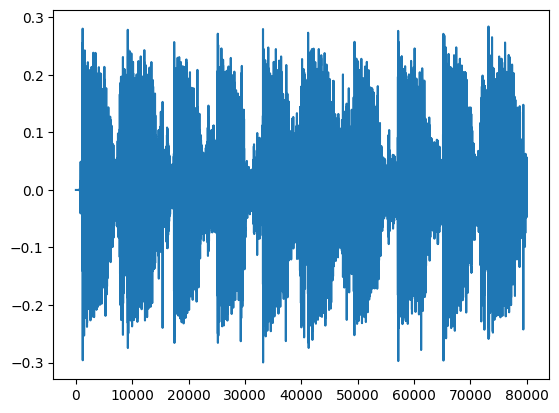

In [ ]:
audio_pathes = {
    1:"audio/invertibility/p232_001.wav",
    2:"audio/invertibility/p232_002.wav",
    3:"audio/invertibility/15033000.mp3",
    4:"audio/invertibility/16366200.mp3",
    5:"audio/invertibility/16129994.mp3",
    6:"audio/invertibility/16176213.mp3",
}

audio_path = audio_pathes[3]
waveform = audio_loader.load_segment(audio_path, offset=0, duration=5, nchannels=1)
loudness = audio_loader.measure_loudness(waveform)
waveform = audio_loader.normalise_loudness(waveform, loudness, target_lufs=-23)

plt.plot(waveform[0])
ipd.Audio(waveform, rate=SAMPLE_RATE, autoplay=False)

wav_in tensor(-0.3018) tensor(0.2852)
spectrogram: tensor(-0.1756) tensor(0.1567)
wav_ou tensor(-0.2940) tensor(0.2789)
post-quantization: tensor(128) tensor(886)
post-dequantization: tensor(-0.1757) tensor(0.1554)


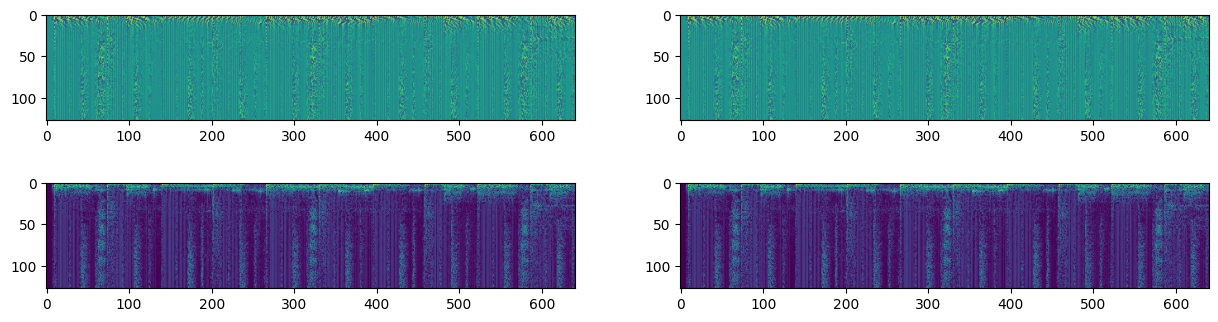

In [20]:
q_bits = 10
quantizer = Quantizer(q_bits=q_bits)


with torch.no_grad():
    # trnsform the waveform into tensor
    wav = torch.from_numpy(waveform).to(device).float()
    print("wav_in", wav.min(), wav.max())
    scale = "lin"

    #encode and decode waveform
    s = sinc.encode(wav.unsqueeze(0), scale=scale)
    print("spectrogram:", s.min(), s.max())

    reconstructed_wav = sinc.decode(s, scale=scale)
    print("wav_ou", reconstructed_wav.min(), reconstructed_wav.max())

    #apply quantization
    sq = quantizer(s)
    print("post-quantization:", sq.min(), sq.max())
    sr = quantizer.inverse(sq)
    print("post-dequantization:", sr.min(), sr.max())
    detokenized_wav = sinc.decode(sr, scale=scale)

    #apply mu-law-companding for visualization
    s = compute_forward_mu_law_companding(s, q_bits=q_bits)
    sr = compute_forward_mu_law_companding(sr, q_bits=q_bits)


f, axes = plt.subplots(2, 2, figsize=(15, 4))
y = s[0].detach().numpy()
yr = sr[0].detach().numpy()

axes[0,0].imshow(y)
axes[1,0].imshow(np.abs(y))

axes[0,1].imshow(yr)
axes[1,1].imshow(np.abs(yr))

# Create your Audio objects
audio1 = ipd.Audio(reconstructed_wav, rate=SAMPLE_RATE, autoplay=False)
audio2 = ipd.Audio(detokenized_wav, rate=SAMPLE_RATE, autoplay=False)
# Embed them in HTML with flexbox for horizontal layout
html_content = f"""
<div style="display:flex; justify-content:space-around;">
    <div>
        <h3>Reconstructed waveform</h3>
        {audio1._repr_html_()}
    </div>
    <div>
        <h3>Dequantized waveform</h3>
        {audio2._repr_html_()}
    </div>
</div>
"""
# Display the HTML
display(HTML(html_content))

## 2 - Linearity Test

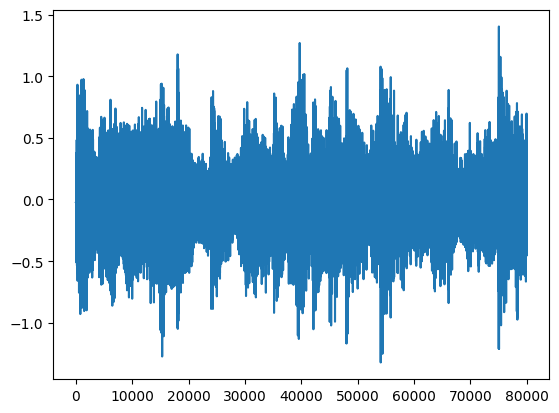

In [ ]:
audio_pathes = {
    0:"audio/stems/stem_pad.wav",
    1:"audio/stems/stem_drum1.wav",
    2:"audio/stems/stem_drum2.wav",

}

selection = [0,1]

wavs = []
for choice in selection:
    audio_path = audio_pathes[choice]
    waveform = audio_loader.load_segment(audio_path, offset=0, duration=5, nchannels=1)
    wavs.append(waveform)

mix = sum(wavs)
wavs.insert(0, mix)

plt.plot(mix[0])
ipd.Audio(mix, rate=SAMPLE_RATE, autoplay=False)

In [ ]:
spectrograms = []
reconstructed = []
scale = "mel"

with torch.no_grad():
    for i, waveform in enumerate(wavs):
        x = torch.from_numpy(waveform).to(device)
        s = sinc.encode(x, scale=scale)
        spectrograms.append(s)
        wav = sinc.decode(s)
        reconstructed.append(wav)

        display(ipd.Audio(waveform, rate=SAMPLE_RATE, autoplay=False))

In [ ]:
s_mix_true = spectrograms[0]
s_mix_linear = torch.cat(spectrograms[1:], dim=0).sum(dim=0)
assert torch.allclose(s_mix_true, s_mix_linear, rtol=1e-2)